In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/1_monday.csv',sep=';', parse_dates=True )
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_c = df.copy()
df.head(5)

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [3]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['min'] = df['timestamp'].dt.minute
df['sec'] = df['timestamp'].dt.second
df['price']=df['location']
df.price = df.price.map( {'checkout':0,'fruit':4,'spices':3,'dairy':5,'drinks':6} )
df.head(5)

,timestamp,customer_no,location,date,hour,min,sec,price
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3


### - 1.Calculate the total number of customers in each section

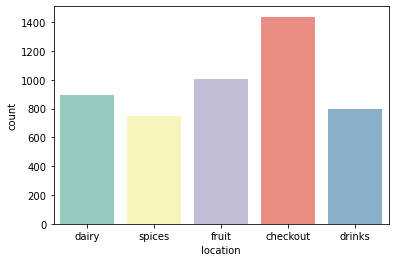

In [4]:
df1 = df.groupby(['location'])[['customer_no']].count()
sns.countplot(x = df['location'], data =df1, palette = 'Set3')
# df1.head(15)#
# df1.plot()

### - 2.Calculate the total number of customers in each section over time


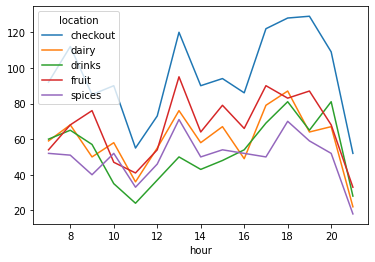

In [5]:
df2 = df.groupby(['location','hour'])[['customer_no']].count().unstack(0)
df2['customer_no'].plot()
# print(df2['customer_no'])

### - 3.Display the number of customers at checkout over time


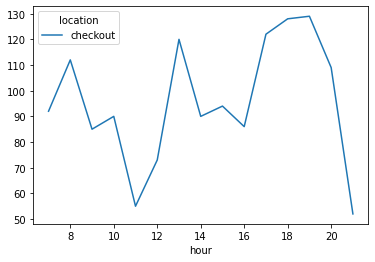

In [29]:
df3 = df.groupby(['location','hour'])[['customer_no']].count().unstack(0)
# print(df3['customer_no'][['checkout']].head(3))
df3['customer_no'][['checkout']].plot()

### - 4.Calculate the time each customer spent in the market


In [7]:
def time_spent(customer_no):
    df_cx = df[df['customer_no']==customer_no]
    df_cx_min = df_cx['timestamp'].min()
    df_cx_max = df_cx['timestamp'].max()
    spent_time = df_cx_max - df_cx_min
    return spent_time    

In [8]:
df4=df.copy()
df4['Spent_time'] = df4['customer_no'].apply(time_spent)
df4 = df4[['Spent_time','customer_no']]
# print(len(df4))
df4.drop_duplicates(inplace=True)
# print(len(df4))
df4['Spent_time'] = df4['Spent_time'].astype('timedelta64[m]')

In [9]:
# df4.info()
# df4.describe()

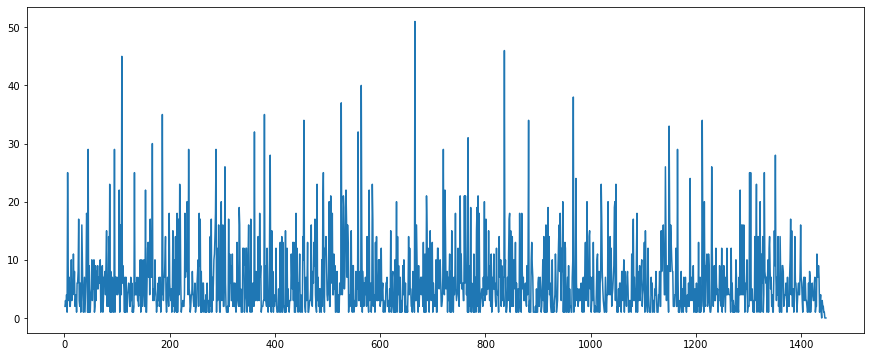

In [10]:
df4.head(10)#
fig, ax = plt.subplots(figsize = (15, 6)) 
plt.plot(df4['customer_no'],df4['Spent_time'])

In [11]:
difference=df.groupby('customer_no')[['timestamp']].agg(lambda x: x.max() - x.min()) ## one liner from Diana
difference.head(5)

,timestamp
customer_no,
1,00:02:00
2,00:03:00
3,00:02:00
4,00:04:00
5,00:01:00


### - 5.Calculate the total number of customers in the supermarket over time.


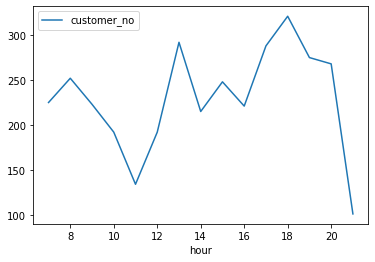

In [33]:
df5 = df[df.location != 'checkout'].groupby(['hour'])[['customer_no']].count()
# df5 = df.groupby(['hour'])[['customer_no']].count() 
df5.plot()

## - Revenue calculation

Text(-2.700000000000003, 0.5, 'Revenue per hour')

<Figure size 1080x360 with 0 Axes>

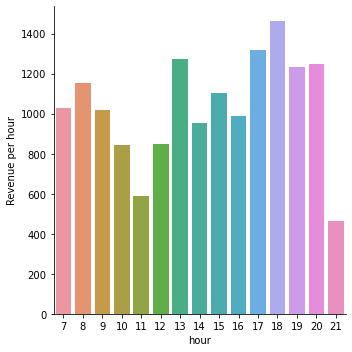

In [27]:
#Revenue per hour
plt.figure(figsize=(15,5))
df_revenue_hour = df.groupby('hour').agg({"price": 'sum'})
df_revenue_hour.reset_index(inplace=True)
sns.catplot(x='hour',y='price', data=df_revenue_hour, kind='bar')
plt.ylabel('Revenue per hour')

Text(0.5, 6.79999999999999, 'Section')

<Figure size 576x360 with 0 Axes>

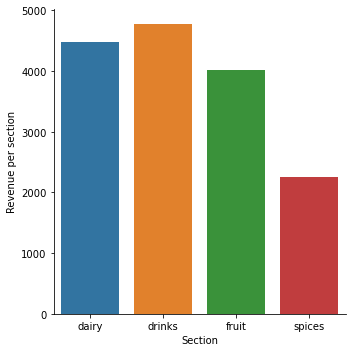

In [28]:
#Revenue per section
plt.figure(figsize=(8,5))
df_revenue_section = df.loc[(df['location'] != 'checkout'),:].copy()
df_revenue_section = df_revenue_section.groupby('location').agg({"price": 'sum'})
df_revenue_section.reset_index(inplace=True)
sns.catplot(x='location',y='price',data=df_revenue_section,kind='bar')
plt.ylabel('Revenue per section')
plt.xlabel('Section')

## - Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

- Customer came into first dairy section , collect those forst entry 

In [13]:
df6 = df.copy()
df6['started_dairy']= 0
df6['started_drinks']= 0
df6['started_fruits']= 0
df6['started_spices']= 0
df6['Finished_checkout']= 0
df6.head(5)
# df.shape#

,timestamp,customer_no,location,date,hour,min,sec,price,started_dairy,started_drinks,started_fruits,started_spices,Finished_checkout
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,0,0,0,0,0
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5,0,0,0,0,0
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5,0,0,0,0,0
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5,0,0,0,0,0
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3,0,0,0,0,0


In [14]:
def shelf_pointer(customer_no):
    df6_new = df6[df6['customer_no']==customer_no]
    df6_new.sort_values(by='timestamp')
    
    if df6_new.iloc[0,2] == 'dairy':
        df6['started_dairy'] = 1
    

In [15]:
df6['customer_no'].apply(shelf_pointer)
df6

,timestamp,customer_no,location,date,hour,min,sec,price,started_dairy,started_drinks,started_fruits,started_spices,Finished_checkout
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,1,0,0,0,0
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5,1,0,0,0,0
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5,1,0,0,0,0
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5,1,0,0,0,0
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,2019-09-02 21:49:00,1442,checkout,2019-09-02,21,49,0,0,1,0,0,0,0
4880,2019-09-02 21:49:00,1444,checkout,2019-09-02,21,49,0,0,1,0,0,0,0
4881,2019-09-02 21:49:00,1445,dairy,2019-09-02,21,49,0,5,1,0,0,0,0
4882,2019-09-02 21:50:00,1446,dairy,2019-09-02,21,50,0,5,1,0,0,0,0


### From another 

In [16]:
df['arrived']= df.groupby('customer_no')[['timestamp']].transform(min)
df['checkout']= df.groupby('customer_no')[['timestamp']].transform(max)
df['spent_time'] = df['checkout']-df['arrived']
df['spent_time'] = df['spent_time'].astype('timedelta64[m]')
df.head(5)

,timestamp,customer_no,location,date,hour,min,sec,price,arrived,checkout,spent_time
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0


In [17]:
df100 = df.copy()
df100 = df.groupby(['location'])[['timestamp']].min()
# df100 = df100.unstack(1)['timestamp']
df100
# df100 = df.groupby(['location','customer_no'])[['timestamp']].min()
# df100.unstack(1)['timestamp']

,timestamp
location,
checkout,2019-09-02 07:05:00
dairy,2019-09-02 07:03:00
drinks,2019-09-02 07:05:00
fruit,2019-09-02 07:04:00
spices,2019-09-02 07:04:00


In [18]:
df101=df.copy()
df101.head(5)

,timestamp,customer_no,location,date,hour,min,sec,price,arrived,checkout,spent_time
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0


In [19]:
df101_new = df101[df['customer_no']==1]
df101_new

,timestamp,customer_no,location,date,hour,min,sec,price,arrived,checkout,spent_time
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
8,2019-09-02 07:05:00,1,checkout,2019-09-02,7,5,0,0,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0


In [20]:
def add_col(df):
#     df_c7 = df101[df101['customer_no']==customer_no]
    df_c7_new = df
    x = df_c7_new.customer_no.values
    
    df_c7 = df_c7_new[df_c7_new['customer_no']==x]
    df_c7.sort_values(by='timestamp')
    
    if df_c7.iloc[0,2] == 'dairy':
        df_c7['started_dairy'] = df_c7.iloc[0,2]
    elif df_c7.iloc[0,2] == 'checkout':
        df_c7['started_checkout'] = df_c7.iloc[0,2]
    elif df_c7.iloc[0,2] == 'drinks':
        df_c7['started_drinks'] = df_c7.iloc[0,2]
    elif df_c7.iloc[0,2] == 'fruit':
        df_c7['started_fruit'] = df_c7.iloc[0,2]
    elif df_c7.iloc[0,2] == 'spices':
        df_c7['started_spices'] = df_c7.iloc[0,2]
    
    return df_c7

In [21]:
df101_new=add_col(df101)

In [22]:
df101_new

,timestamp,customer_no,location,date,hour,min,sec,price,arrived,checkout,spent_time,started_dairy
0,2019-09-02 07:03:00,1,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0,dairy
1,2019-09-02 07:03:00,2,dairy,2019-09-02,7,3,0,5,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0,dairy
2,2019-09-02 07:04:00,3,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0,dairy
3,2019-09-02 07:04:00,4,dairy,2019-09-02,7,4,0,5,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0,dairy
4,2019-09-02 07:04:00,5,spices,2019-09-02,7,4,0,3,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0,dairy
...,...,...,...,...,...,...,...,...,...,...,...,...
4879,2019-09-02 21:49:00,1442,checkout,2019-09-02,21,49,0,0,2019-09-02 21:47:00,2019-09-02 21:49:00,2.0,dairy
4880,2019-09-02 21:49:00,1444,checkout,2019-09-02,21,49,0,0,2019-09-02 21:48:00,2019-09-02 21:49:00,1.0,dairy
4881,2019-09-02 21:49:00,1445,dairy,2019-09-02,21,49,0,5,2019-09-02 21:49:00,2019-09-02 21:49:00,0.0,dairy
4882,2019-09-02 21:50:00,1446,dairy,2019-09-02,21,50,0,5,2019-09-02 21:50:00,2019-09-02 21:50:00,0.0,dairy


In [23]:
df.sort_values

<bound method DataFrame.sort_values of                timestamp  customer_no  location        date  hour  min  sec  \
0    2019-09-02 07:03:00            1     dairy  2019-09-02     7    3    0   
1    2019-09-02 07:03:00            2     dairy  2019-09-02     7    3    0   
2    2019-09-02 07:04:00            3     dairy  2019-09-02     7    4    0   
3    2019-09-02 07:04:00            4     dairy  2019-09-02     7    4    0   
4    2019-09-02 07:04:00            5    spices  2019-09-02     7    4    0   
...                  ...          ...       ...         ...   ...  ...  ...   
4879 2019-09-02 21:49:00         1442  checkout  2019-09-02    21   49    0   
4880 2019-09-02 21:49:00         1444  checkout  2019-09-02    21   49    0   
4881 2019-09-02 21:49:00         1445     dairy  2019-09-02    21   49    0   
4882 2019-09-02 21:50:00         1446     dairy  2019-09-02    21   50    0   
4883 2019-09-02 21:50:00         1447     fruit  2019-09-02    21   50    0   

      price 

In [24]:
df_c7 = df[df['customer_no']==1]
df_c7.sort_values(by='timestamp')
df_c7_min = df_c7['timestamp'].min()
df_c7_max = df_c7['timestamp'].max()
df_diff = df_c7_max-df_c7_min
df_c7['spent_time'] = df_diff
print(x)
# print(df_c7.iloc[0,2])
# print(df_c7.location.values)

if df_c7.iloc[0,2] == 'dairy':
    df_c7['started_dairy'] = df_c7.iloc[0,2]
elif df_c7.iloc[0,2] == 'checkout':
    df_c7['started_checkout'] = df_c7.iloc[0,2]
elif df_c7.iloc[0,2] == 'drinks':
    df_c7['started_drinks'] = df_c7.iloc[0,2]
elif df_c7.iloc[0,2] == 'fruit':
    df_c7['started_fruit'] = df_c7.iloc[0,2]
elif df_c7.iloc[0,2] == 'spices':
    df_c7['started_spices'] = df_c7.iloc[0,2]


# df_c7_new = pd.DataFrame[['timestamp','customer_no','location','started_dairy', 'transition_state']]
# df_c7_new =

# y = df_c7.location.values
# print(y)
# df_c7['transition_state'] = y
    

print(df_diff)
df_c7

<ipython-input-24-1fcf7c26f110>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c7['spent_time'] = df_diff


NameError: name 'x' is not defined

In [ ]:
def time_spent(customer_no):
    df_cx = df_c[df_c['customer_no']==customer_no]
    df_cx_min = df_cx['timestamp'].min()
    df_cx_max = df_cx['timestamp'].max()
    spent_time = df_cx_max - df_cx_min
    
    return spent_time    

df_c['Spent_time'] = df_c['customer_no'].apply(time_spent)
df_c

In [ ]:
df_c[df_c['customer_no']==1433]